In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import random
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from hyperopt import hp, tpe, fmin, STATUS_OK
from sklearn.metrics import roc_curve

# Functions, classes and etc

In [2]:
def SEED_EVERYTHING(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

# EDA

In [3]:
PROJ_PATH = '/home/kirill/projects/personal_projects/A1_10_22/'
DATA_PATH = '/home/kirill/data/A1/'
csv_path = DATA_PATH + 'Задания_1_2.xlsx'

training_df = pd.read_excel(csv_path, sheet_name='Training')
validate_df = pd.read_excel(csv_path, sheet_name='Validate')

### Initial view

In [15]:
training_df

,ID,Target,P1,P2,P3,P4,P5,P6,P7,P8,...,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31
0,283,1,0.0,NaN,NaN,10,0,1.02273,1.01608,1.55268,...,831.68333,783.81667,171.33333,818.15000,0.62772,0.13333,0.00000,6.41893,0.97122,6.41893
1,342,0,0.0,30.00000,6.80153,0,0,1.00000,1.65348,1.14852,...,195.13889,168.30000,81.00000,NaN,6.32407,0.26667,0.33333,NaN,1.60714,3.44800
2,631,0,0.0,30.00000,9.60267,0,0,1.00000,0.84143,NaN,...,226.10556,207.41667,110.00000,184.49444,2.25635,0.00000,0.06667,NaN,0.75000,8.08000
3,1165,0,0.0,30.33333,15.32553,0,0,0.98901,0.88114,NaN,...,567.53889,441.52778,194.00000,625.32222,2.74469,0.13333,0.40000,13.50400,0.98119,13.50400
4,1469,0,0.0,28.00000,7.54133,0,0,0.92857,1.21447,0.60138,...,154.80556,86.64444,71.66667,53.45000,0.91130,0.46667,0.40000,NaN,0.40171,3.44800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,12590517,0,0.0,18.00000,4.73720,0,0,0.83333,0.94478,0.54532,...,35.63889,33.57422,25.66667,27.52778,0.59411,0.26667,0.26667,3.08000,0.83333,3.08000
9996,12594579,0,0.0,8.00000,7.74710,29,0,0.50000,1.03436,0.29789,...,72.47222,68.27194,20.33333,32.30556,1.47413,0.20000,0.33333,NaN,1.11434,7.36710
9997,12844266,0,0.0,30.33333,NaN,0,0,0.98901,1.12891,1.55649,...,212.78889,183.60606,137.66667,225.65556,0.94152,0.20000,0.33333,16.60000,0.78899,16.60000
9998,12857302,0,0.0,28.66667,6.70950,0,0,1.01163,1.02243,0.86369,...,96.41667,100.09256,74.33333,363.32778,0.61164,0.00000,0.00000,6.56000,1.03121,6.56000


In [4]:
validate_df

,ID,Target,P1,P2,P3,P4,P5,P6,P7,P8,...,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31
0,127,NaN,0.0,30.33333,8.86883,0,0,0.98901,1.01885,1.31226,...,85.59444,32.45000,41.00000,95.39444,4.64779,0.40000,0.73333,8.256,0.11725,8.256
1,214,NaN,0.0,30.33333,12.82570,0,0,0.98901,0.96587,0.94475,...,809.37778,787.77778,164.66667,239.95000,2.34907,0.00000,0.00000,4.320,1.33333,10.000
2,542,NaN,0.0,9.00000,5.25643,0,0,0.88889,0.97863,1.68000,...,26.34444,25.89444,1.33333,1.26667,0.43333,0.13333,0.06667,5.096,1.16688,5.096
3,674,NaN,0.0,24.33333,NaN,0,0,0.90411,0.88409,0.58490,...,116.31111,73.20000,27.33333,34.62222,0.69722,0.33333,0.13333,4.712,1.80000,4.712
4,756,NaN,0.0,30.33333,21.90167,0,0,0.98901,1.02636,1.30082,...,275.16111,201.13889,285.00000,369.42778,1.36109,0.13333,0.13333,21.096,0.00000,21.096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,8811962,NaN,0.0,30.33333,NaN,0,0,0.98901,1.12578,1.79481,...,39.74444,28.36094,58.33333,38.41111,0.88089,0.26667,0.33333,8.256,1.35638,8.256
19996,8832072,NaN,0.0,30.33333,NaN,1,0,0.98901,1.17395,1.02346,...,187.14444,134.79028,138.00000,126.64444,1.83841,0.26667,0.13333,NaN,1.23517,4.920
19997,8839360,NaN,0.0,26.00000,13.55420,0,0,0.84615,0.81721,0.57453,...,66.17778,68.90206,94.66667,105.41111,2.56944,0.00000,0.06667,4.712,0.49750,4.712
19998,8839754,NaN,0.0,30.33333,10.54000,0,0,0.98901,0.95256,0.88781,...,874.98889,602.29706,79.00000,NaN,4.79597,0.33333,0.06667,9.920,1.00000,9.920


In [16]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 33 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      10000 non-null  int64  
 1   Target  10000 non-null  int64  
 2   P1      10000 non-null  float64
 3   P2      8492 non-null   float64
 4   P3      8523 non-null   float64
 5   P4      10000 non-null  int64  
 6   P5      10000 non-null  int64  
 7   P6      10000 non-null  float64
 8   P7      10000 non-null  float64
 9   P8      8482 non-null   float64
 10  P9      10000 non-null  float64
 11  P10     10000 non-null  float64
 12  P11     10000 non-null  float64
 13  P12     10000 non-null  float64
 14  P13     10000 non-null  float64
 15  P14     10000 non-null  float64
 16  P15     10000 non-null  float64
 17  P16     8475 non-null   float64
 18  P17     10000 non-null  float64
 19  P18     10000 non-null  float64
 20  P19     10000 non-null  float64
 21  P20     10000 non-null  float64
 22 

### Nan values columns?

In [29]:
not_show_columns = ['ID', 'Target']
show_columns = [i for i in training_df.columns if i not in not_show_columns]

for i in show_columns:
    nans = training_df[i].isna()
    if nans.any():
        snans = nans.sum()
        
        print(f"NAN column {i}, number of nans {snans}")

NAN column P2, number of nans 1508
NAN column P3, number of nans 1477
NAN column P8, number of nans 1518
NAN column P16, number of nans 1525
NAN column P25, number of nans 1504
NAN column P29, number of nans 1533


### Number of duplicates

In [6]:
print("Number of duplications in train/val df: ")
print(training_df.duplicated().sum())
print(validate_df.duplicated().sum())

Number of duplications in train/val df: 
0
0


### Distribution of features (training)

Blue - all targets, Green - target 1, Red - target 0


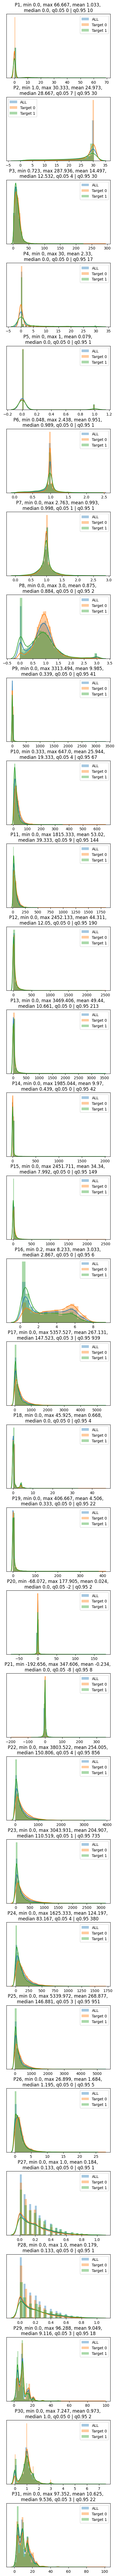

In [36]:
not_show_columns = ['ID', 'Target']
show_columns = [i for i in training_df.columns if i not in not_show_columns]

_, axs = plt.subplots(ncols=1, nrows=len(show_columns), figsize=(5, 4 * len(show_columns)))
print("Blue - all targets, Green - target 1, Red - target 0")

plt.subplots_adjust(hspace=0.3)

targets = training_df['Target']
for i, col in enumerate(show_columns):
    col_all = training_df[col]
    col_all = col_all.dropna()
    col_1 = col_all[targets.astype(bool)]
    col_0 = col_all[~targets.astype(bool)]
    
    sns.distplot(col_all, ax=axs[i], fit_kws={'color': 'blue'}, hist=True, label='ALL');
    sns.distplot(col_0, ax=axs[i], fit_kws={'color': 'red'}, hist=True, label='Target 0');
    sns.distplot(col_1, ax=axs[i], fit_kws={'color': 'green'}, hist=True, label='Target 1');
    
    vmin, vmax = round(col_all.min(), 3), round(col_all.max(), 3)
    vmean, vmedian = round(col_all.mean(), 3), round(col_all.median(), 3)
    q05, q95 = col_all.quantile(0.05), col_all.quantile(0.95)
    axs[i].set_title(f"{col}, min {vmin}, max {vmax}, mean {vmean}, \nmedian {vmedian}, q0.05 {round(q05)} | q0.95 {round(q95)}")
    axs[i].set(xlabel='', ylabel=None, yticklabels=[])
    axs[i].tick_params(left=False)
    axs[i].legend()
    
    #sns.distplot(col_all, ax=axs[i][1], fit_kws={'color': 'blue'});
    #sns.distplot(col_1, ax=axs[i][1], fit_kws={'color': 'green'});
    #sns.distplot(col_0, ax=axs[i][1], fit_kws={'color': 'red'});
    #q05, q95 = col_all.quantile(0.05), col_all.quantile(0.95)
    #axs[i][1].set_xlim(q05, q95)
    #axs[i][1].set_title(f"{col} w/t outliers, q0.05 {round(q05)} | q0.95 {round(q95)}")
    #axs[i][1].set(xlabel='')
    

### Distribution of features (validation)

VALIDATE.


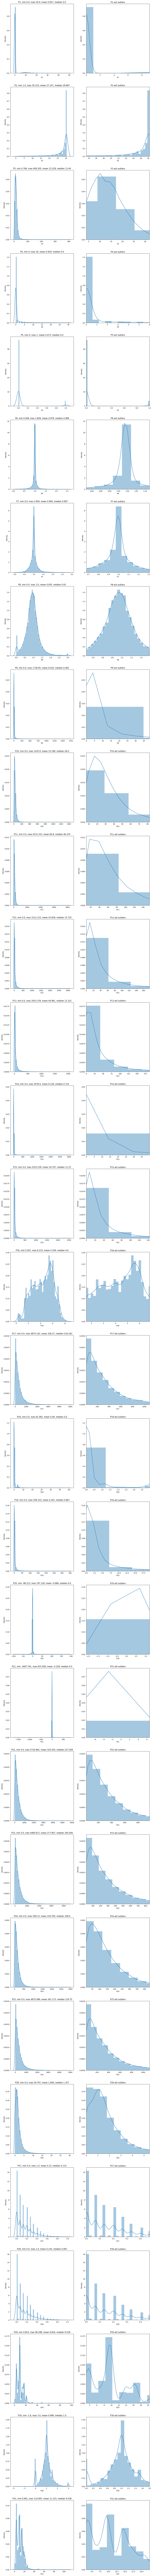

In [11]:
not_show_columns = ['ID', 'Target']
show_columns = [i for i in validate_df.columns if i not in not_show_columns]

_, axs = plt.subplots(ncols=2, nrows=len(show_columns), figsize=(15, 9 * len(show_columns)))
print("VALIDATE.")

targets = training_df['Target']
for i, col in enumerate(show_columns):
    col_all = validate_df[col]
    col_all = col_all.dropna()
    
    sns.distplot(col_all, ax=axs[i][0], fit_kws={'color': 'blue'});
    vmin, vmax = round(col_all.min(), 3), round(col_all.max(), 3)
    vmean, vmedian = round(col_all.mean(), 3), round(col_all.median(), 3)
    axs[i][0].set_title(f"{col}, min {vmin}, max {vmax}, mean {vmean}, median {vmedian}")
    
    sns.distplot(col_all, ax=axs[i][1], fit_kws={'color': 'blue'});
    axs[i][1].set_xlim(col_all.quantile(0.05), col_all.quantile(0.95))
    axs[i][1].set_title(f"{col} w/t outliers")
    

### Target distribution

Target distribution in training set 1/0: 50.0%/50.0%


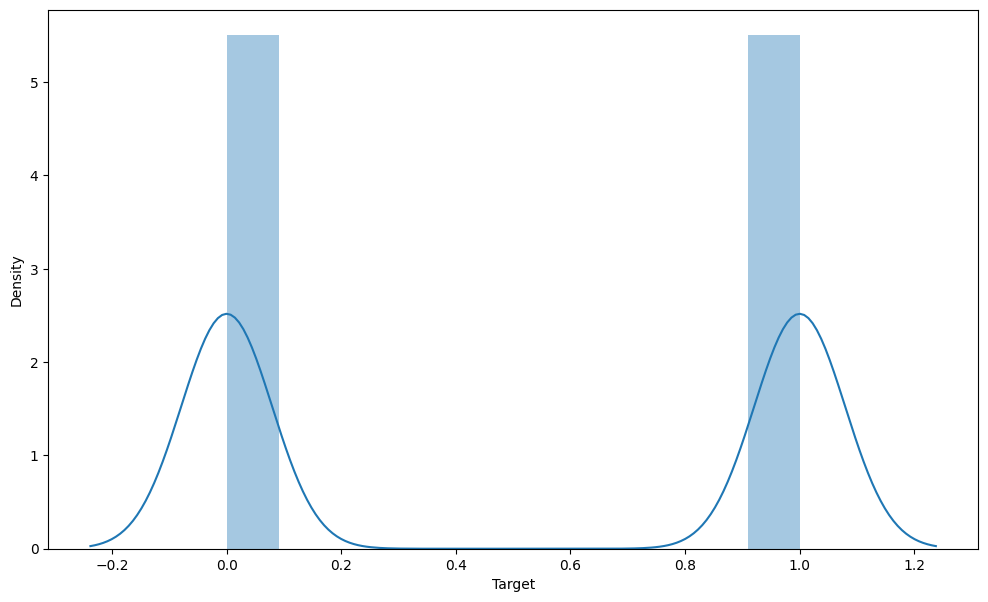

In [15]:
_, axs = plt.subplots(ncols=1, figsize=(12, 7))

ttar1_p = training_df['Target'].sum() / len(training_df)
ttar0_p = 1 - ttar1_p
sns.distplot(training_df['Target'], ax=axs)

print(f"Target distribution in training set 1/0: {ttar1_p*100}%/{ttar0_p*100}%")

### ID is unique?

In [21]:
unique_ids = training_df['ID'].unique()
print("ID is Unique?", (len(training_df) == len(unique_ids)))

ID is Unique? True


### Validation set have ID's from training set?

In [30]:
train_ids = training_df['ID'].unique()
val_ids = validate_df['ID'].unique()

print("Val have ids from train?", len(set(train_ids).intersection(val_ids)) != 0)

Val have ids from train? False


### Target distribution for nan/no-nan cases


Feature P2
Target dist. in NAN cases 1/0: 51.33%/48.67%
Target dist. in noNAN cases 1/0: 49.76%/50.24%

Feature P3
Target dist. in NAN cases 1/0: 48.88%/51.12%
Target dist. in noNAN cases 1/0: 50.19%/49.81%

Feature P8
Target dist. in NAN cases 1/0: 50.59%/49.41%
Target dist. in noNAN cases 1/0: 49.89%/50.11%

Feature P16
Target dist. in NAN cases 1/0: 50.03%/49.97%
Target dist. in noNAN cases 1/0: 49.99%/50.01%

Feature P25
Target dist. in NAN cases 1/0: 49.87%/50.13%
Target dist. in noNAN cases 1/0: 50.02%/49.98%

Feature P29
Target dist. in NAN cases 1/0: 52.05%/47.95%
Target dist. in noNAN cases 1/0: 49.63%/50.37%


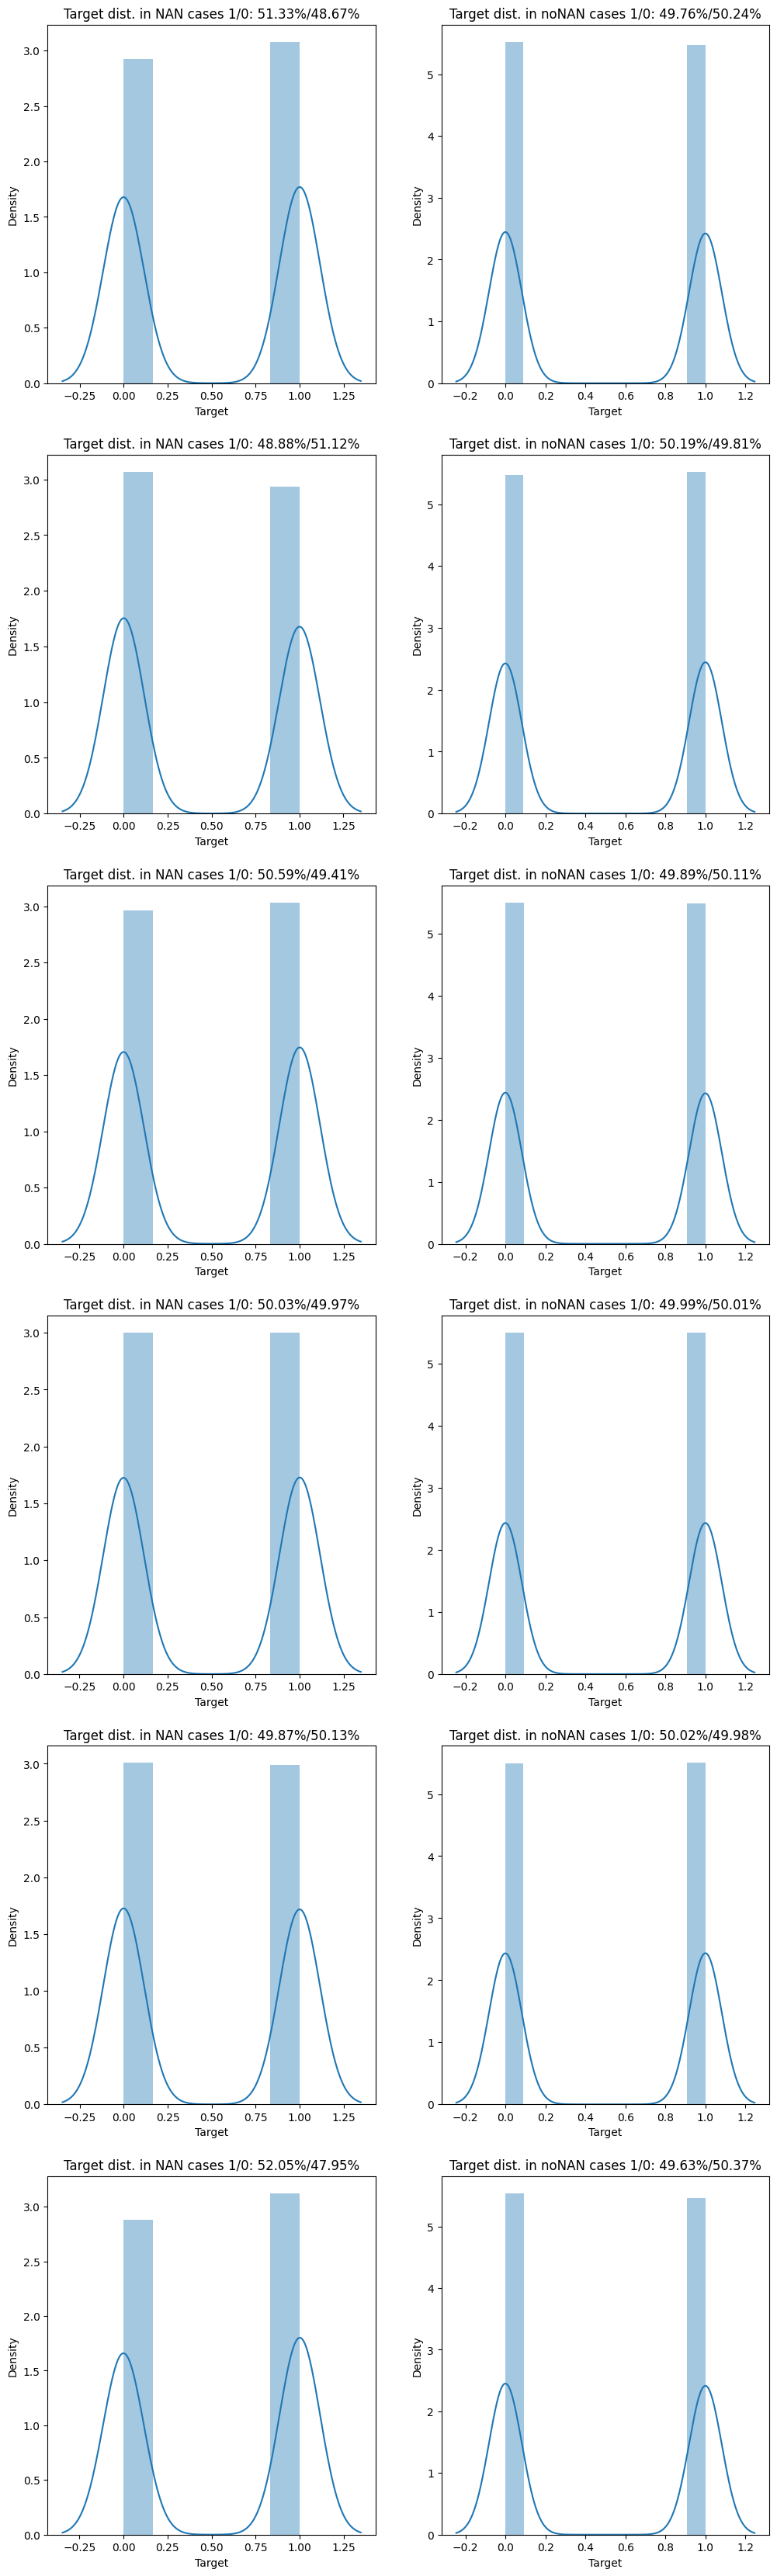

In [40]:
not_show_columns = ['ID', 'Target']
nan_columns = [i for i in training_df.columns if i not in not_show_columns and training_df[i].isna().any()]
target = training_df['Target']

_, axs = plt.subplots(ncols=2, nrows=len(nan_columns), figsize=(12, 7 * len(nan_columns)))

for i, col in enumerate(nan_columns):
    target_nans = target[training_df[col].isna()]
    target_nnans = target[~training_df[col].isna()]
    
    nan_tar1_p = round(target_nans.sum() / len(target_nans), 4)
    nnan_tar1_p = round(target_nnans.sum() / len(target_nnans), 4)
    nan_tar0_p, nnan_tar0_p = round(1 - nan_tar1_p, 4), round(1 - nnan_tar1_p, 4)
    
    sns.distplot(target_nans, ax=axs[i][0])
    sns.distplot(target_nnans, ax=axs[i][1])
    axs[i][0].set_title(f"Target dist. in NAN cases 1/0: {round(nan_tar1_p*100, 4)}%/{round(nan_tar0_p*100, 4)}%")
    axs[i][1].set_title(f"Target dist. in noNAN cases 1/0: {round(nnan_tar1_p*100, 4)}%/{round(nnan_tar0_p*100, 4)}%")
    
    print(f"\nFeature {col}")
    print(f"Target dist. in NAN cases 1/0: {round(nan_tar1_p*100, 4)}%/{round(nan_tar0_p*100, 4)}%")
    print(f"Target dist. in noNAN cases 1/0: {round(nnan_tar1_p*100, 4)}%/{round(nnan_tar0_p*100, 4)}%")
    
    
    

### Pearson correlation

<AxesSubplot:>

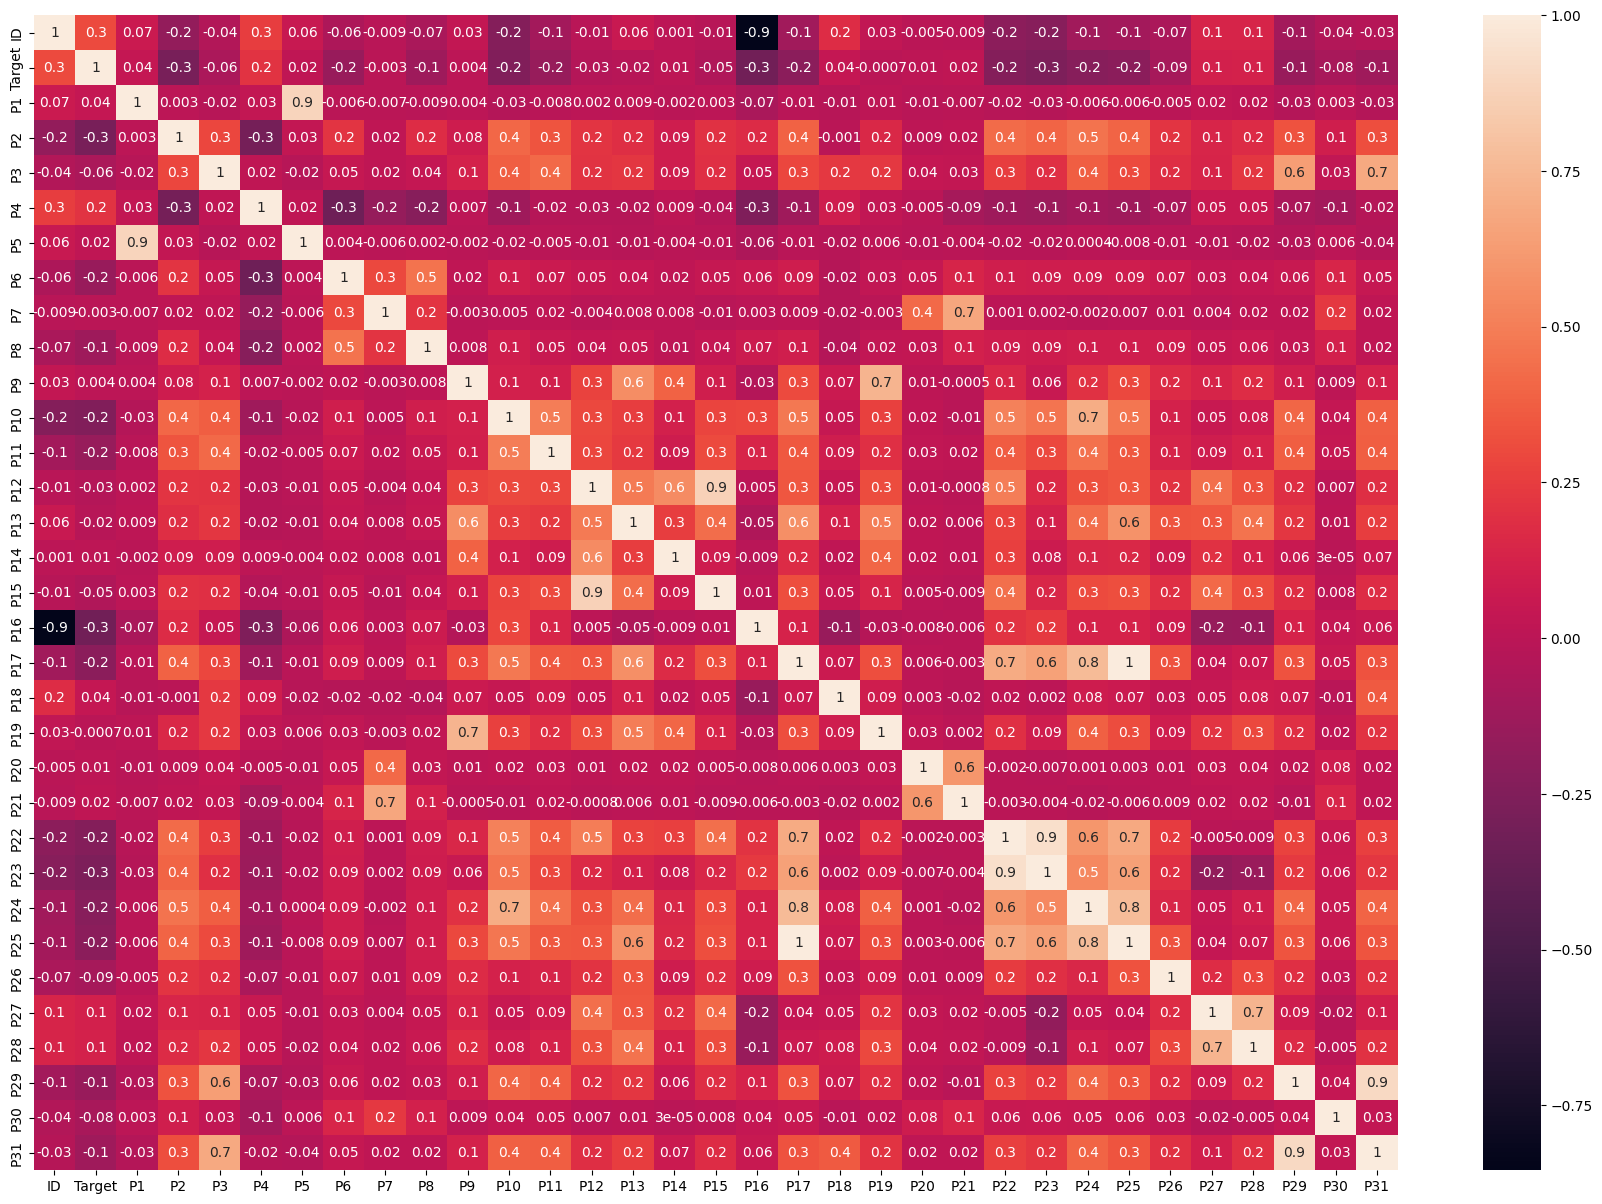

In [46]:
_, ax = plt.subplots(figsize=(22, 15))
sns.heatmap(training_df.corr(), annot=True, ax=ax, fmt='.1g')

### How much(in %) rows exists without any NAN's?

In [107]:
p = len(training_df.dropna(axis=0)) / len(training_df)
print(f"{p * 100}%")

37.169999999999995%


# Training, testing

In [ ]:
PROJ_PATH = '/home/kirill/projects/personal_projects/A1_10_22/'
DATA_PATH = '/home/kirill/data/A1/'
csv_path = DATA_PATH + 'Задания_1_2.xlsx'

training_df = pd.read_excel(csv_path, sheet_name='Training')

RAND_SEED = 42
N_SPLITS = 4
SEED_EVERYTHING(RAND_SEED)

In [ ]:
def v1_preprocessing(df, fill_nan=-999, dropcols=['ID', 'Target']):
    df = df.drop(dropcols, axis=1)
    df = df.fillna(value=fill_nan)
    return df


def v2_preprocessing(df, fill_nan=-999, dropcols=['ID', 'Target'], q_clip=(0.03, 0.97)):
    df = df.drop(dropcols, axis=1)
    
    for col in df.columns:
        df_col = df[col]
        df[col] = df_col.clip(df_col.quantile(q_clip[0]), df_col.quantile(q_clip[1]))
        
    df = df.fillna(value=fill_nan)
    return df


def v3_preprocessing(df, fill_nan=-999, dropcols=['ID', 'Target']):
    df = df.drop(dropcols, axis=1)
    
    for col in df.columns:
        df_col = df[col]
        col_mean, col_std = df_col.mean(), df_col.std()
        df[col] = (df_col - col_mean) / col_std

    df = df.fillna(value=fill_nan)
    return df


def v4_preprocessing(df, fill_nan=-999, dropcols=['ID', 'Target']):
    df = df.drop(dropcols, axis=1)
    
    for col in df.columns:
        nans = df[col].isna()
        if nans.any():
            df[f'{col}_isnan'] = nans.astype(int)
            
    df = df.fillna(value=fill_nan)
    return df


def v5_preprocessing(df, fill_nan=0, dropcols=['ID', 'Target'], normalize_method='standard_scaler'):
    df = df.drop(dropcols, axis=1)
    
    if normalize_method == 'standard_scaler':
        for col in df.columns:
            df_col = df[col]
            cmean, cstd = df_col.mean(), df_col.std()
            df[col] = (df_col - cmean) / cstd
    elif normalize_method == 'minmax':
        for col in df.columns:
            df_col = df[col]
            cmin, cmax = df_col.min(), df_col.max()
            df[col] = (df_col - cmin) / (cmax - cmin)
            
    df = df.fillna(value=fill_nan)
    return df


def cv_score(model, X, y, n_splits=N_SPLITS, random_state=RAND_SEED):
    skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    scores_f1, scores_ac, scores_roc = [], [], []
    for train_ind, test_ind in skf.split(X, y):
        x_train, y_train = X[train_ind], y[train_ind]
        x_test, y_test = X[test_ind], y[test_ind]
    
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        y_score_pred = model.predict_proba(x_test)
        
        if len(y_score_pred.shape) == 2:
            y_score_pred = y_score_pred[:, 1]
        if len(y_score_pred.shape) == 1:
            y_score_pred = y_score_pred.reshape(-1, 1)
    
        scores_f1.append(f1_score(y_test, y_pred))
        scores_ac.append(accuracy_score(y_test, y_pred))
        scores_roc.append(roc_auc_score(y_test, y_score_pred))
    
    scores_f1 = np.array(scores_f1)
    scores_ac = np.array(scores_ac)
    scores_roc = np.array(scores_roc)
    print(f"Accuracy scores: {scores_ac}, mean: {scores_ac.mean()}")
    print(f"F1 scores: {scores_f1}, mean: {scores_f1.mean()}")
    print(f"ROC AUC scores: {scores_roc}, mean: {scores_roc.mean()}")  
    
    

### V1_1/2. Random forest baseline

In [79]:
# v1_1

training_prep_df = v1_preprocessing(training_df, fill_nan=0)
X, y = training_prep_df.to_numpy(), training_df['Target'].to_numpy().reshape(-1, 1)

rforest = RandomForestClassifier(n_estimators=2000, random_state=RAND_SEED)

cv_score(rforest, X, y, N_SPLITS, RAND_SEED)

Accuracy scores: [0.7016 0.6944 0.688  0.6804], mean: 0.6910999999999999
F1 scores: [0.69773096 0.68892508 0.6914557  0.68180008], mean: 0.6899779533812922
ROC AUC scores: [0.76432    0.76954304 0.75638208 0.74988032], mean: 0.76003136


In [80]:
# v1_2

training_prep_df = v1_preprocessing(training_df, fill_nan=-999)
X, y = training_prep_df.to_numpy(), training_df['Target'].to_numpy().reshape(-1, 1)

rforest = RandomForestClassifier(n_estimators=2000, random_state=RAND_SEED)

cv_score(rforest, X, y, N_SPLITS, RAND_SEED)

Accuracy scores: [0.7004 0.698  0.6896 0.6788], mean: 0.6917
F1 scores: [0.6946596  0.69371197 0.69255151 0.67892843], mean: 0.689962875552534
ROC AUC scores: [0.76374496 0.76915424 0.75581792 0.75035424], mean: 0.7597678400000001


### V2. Random forest + v2_preprocessing

In [81]:
training_prep_df = v2_preprocessing(training_df, fill_nan=-999)
X, y = training_prep_df.to_numpy(), training_df['Target'].to_numpy().reshape(-1, 1)

rforest = RandomForestClassifier(n_estimators=2000, random_state=RAND_SEED)

cv_score(rforest, X, y, N_SPLITS, RAND_SEED)

Accuracy scores: [0.698  0.6992 0.6868 0.6796], mean: 0.6909000000000001
F1 scores: [0.69246436 0.69381107 0.68965517 0.68151093], mean: 0.6893603850445342
ROC AUC scores: [0.7638288  0.76985984 0.7558032  0.7516608 ], mean: 0.76028816


### V3. Random forest + v3_preprocessing

In [82]:
training_prep_df = v3_preprocessing(training_df, fill_nan=-999)
X, y = training_prep_df.to_numpy(), training_df['Target'].to_numpy().reshape(-1, 1)

rforest = RandomForestClassifier(n_estimators=2000, random_state=RAND_SEED)

cv_score(rforest, X, y, N_SPLITS, RAND_SEED)

Accuracy scores: [0.6992 0.698  0.6884 0.6784], mean: 0.691
F1 scores: [0.69331158 0.69346326 0.69148515 0.67891374], mean: 0.6892934312768465
ROC AUC scores: [0.76376224 0.76909984 0.75581344 0.75030944], mean: 0.75974624


### V4. Random forest + v4_preprocessing

In [83]:
training_prep_df = v4_preprocessing(training_df, fill_nan=-999)
X, y = training_prep_df.to_numpy(), training_df['Target'].to_numpy().reshape(-1, 1)

rforest = RandomForestClassifier(n_estimators=2000, random_state=RAND_SEED)

cv_score(rforest, X, y, N_SPLITS, RAND_SEED)

Accuracy scores: [0.7016 0.7016 0.6892 0.6808], mean: 0.6933
F1 scores: [0.69748581 0.69773096 0.69300672 0.68308181], mean: 0.6928263227221425
ROC AUC scores: [0.76377696 0.76952544 0.75535168 0.75078912], mean: 0.7598608


### V5. Logistic regression + v5_preprocessing

In [86]:
training_prep_df = v5_preprocessing(training_df, fill_nan=0, normalize_method='standard_scaler')
X, y = training_prep_df.to_numpy(), training_df['Target'].to_numpy().reshape(-1, 1)

logreg = LogisticRegression()

cv_score(logreg, X, y, N_SPLITS, RAND_SEED)

Accuracy scores: [0.71   0.7084 0.6944 0.688 ], mean: 0.7001999999999999
F1 scores: [0.70347648 0.70545455 0.69826224 0.68924303], mean: 0.6991090748116295
ROC AUC scores: [0.77405376 0.77673792 0.7645024  0.74801984], mean: 0.76582848


### V6. SVC + v5_preprocessing

In [87]:
training_prep_df = v5_preprocessing(training_df, fill_nan=0, normalize_method='standard_scaler')
X, y = training_prep_df.to_numpy(), training_df['Target'].to_numpy().reshape(-1, 1)

svc = SVC(kernel='linear', probability=True)

cv_score(svc, X, y, N_SPLITS, RAND_SEED)

Accuracy scores: [0.7132 0.7084 0.6996 0.6904], mean: 0.7029
F1 scores: [0.70983408 0.71013917 0.70721248 0.6971831 ], mean: 0.7060922036270467
ROC AUC scores: [0.77623008 0.77878048 0.7663392  0.75210048], mean: 0.7683625599999999


###  V7. Gradient boosting trees (lightGBM)

In [88]:
training_prep_df = v4_preprocessing(training_df, fill_nan=0)
X, y = training_prep_df.to_numpy(), training_df['Target'].to_numpy().reshape(-1, 1)

gradforest = lgb.LGBMClassifier(random_state=RAND_SEED, learning_rate=0.01, n_estimators=500)

cv_score(gradforest, X, y, N_SPLITS, RAND_SEED)

Accuracy scores: [0.708  0.7004 0.6896 0.6832], mean: 0.6953
F1 scores: [0.6980976  0.69189634 0.68810289 0.68596352], mean: 0.6910150887960782
ROC AUC scores: [0.76467712 0.76939392 0.75610752 0.74875264], mean: 0.7597328000000001


### V8. LinearSVC + v5_preprocessing

In [93]:
training_prep_df = v5_preprocessing(training_df, fill_nan=0, normalize_method='standard_scaler')
X, y = training_prep_df.to_numpy(), training_df['Target'].to_numpy().reshape(-1, 1)

lsvc = CalibratedClassifierCV(LinearSVC())

cv_score(lsvc, X, y, N_SPLITS, RAND_SEED)

Accuracy scores: [0.7088 0.7144 0.7088 0.6904], mean: 0.7056
F1 scores: [0.70996016 0.72174591 0.71826625 0.7       ], mean: 0.7124930803151446
ROC AUC scores: [0.7766112  0.77567168 0.7707136  0.75164288], mean: 0.7686598399999999


### V9. V8 + tuned hyperparameters(hyperopt)

In [43]:
def objective(params, X, y):
    skf = StratifiedKFold(n_splits=3, random_state=RAND_SEED, shuffle=True)
    model = CalibratedClassifierCV(LinearSVC(**params))
    
    scores_roc = []
    for train_ind, test_ind in skf.split(X, y):
        x_train, y_train = X[train_ind], y[train_ind]
        x_test, y_test = X[test_ind], y[test_ind]
    
        try:
            model.fit(x_train, y_train)
        except ValueError:
            return {'loss': 999, 'status': STATUS_OK}
        
        y_score_pred = model.predict_proba(x_test)
        
        if len(y_score_pred.shape) == 2:
            y_score_pred = y_score_pred[:, 1]
        if len(y_score_pred.shape) == 1:
            y_score_pred = y_score_pred.reshape(-1, 1)
    
        scores_roc.append(roc_auc_score(y_test, y_score_pred))
    
    scores_roc = np.array(scores_roc)
    return {'loss': -scores_roc.mean(), 'status': STATUS_OK}

In [44]:
max_evals = 600
search_space = {
    'penalty': hp.choice(label='penalty', options=['l1', 'l2']),
    'loss': hp.choice(label='loss', options=['hinge', 'squared_hinge']),
    'dual': hp.choice(label='dual', options=[True, False]),
    'tol': hp.loguniform(label='tol', low=-5*np.log(10), high=-3*np.log(10)),
    'C': hp.loguniform(label='C', low=-4*np.log(10), high=2*np.log(10)),
    'max_iter': hp.loguniform(label='max_iter', low=3*np.log(10), high=4*np.log(10))
}

training_prep_df = v5_preprocessing(training_df, fill_nan=0, normalize_method='standard_scaler')
X, y = training_prep_df.to_numpy(), training_df['Target'].to_numpy().reshape(-1, 1)

best = fmin(
    fn=lambda params: objective(params, X, y),
    space=search_space,
    algo=tpe.suggest,
    max_evals=max_evals,
    rstate=np.random.default_rng(RAND_SEED),
    show_progressbar=True
)

print(best)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [1:56:54<00:00, 11.69s/trial, best loss: -0.7756152275422371]
{'C': 99.14701874805526, 'dual': 0, 'loss': 0, 'max_iter': 8263.728499782084, 'penalty': 1, 'tol': 0.0005531398110214415}


In [46]:
training_prep_df = v5_preprocessing(training_df, fill_nan=0, normalize_method='standard_scaler')
X, y = training_prep_df.to_numpy(), training_df['Target'].to_numpy().reshape(-1, 1)

best_params = {
    'C': 99,
    'dual': True,
    'loss': 'hinge',
    'max_iter': 8200,
    'penalty': 'l2',
    'tol': 0.000553
}
lsvc = CalibratedClassifierCV(LinearSVC(**best_params))

cv_score(lsvc, X, y, N_SPLITS, RAND_SEED)

Accuracy scores: [0.7188 0.716  0.7152 0.7016], mean: 0.7129
F1 scores: [0.72656554 0.72734255 0.72552043 0.70790916], mean: 0.7218344206220928
ROC AUC scores: [0.77973504 0.77888768 0.77517248 0.7649088 ], mean: 0.774676


# Submition

In [3]:
PROJ_PATH = '/home/kirill/projects/personal_projects/A1_10_22/'
DATA_PATH = '/home/kirill/data/A1/'
SAVE_PATH = PROJ_PATH + 'data/task2_predicts.csv'
csv_path = DATA_PATH + 'Задания_1_2.xlsx'

training_df = pd.read_excel(csv_path, sheet_name='Training')
validate_df = pd.read_excel(csv_path, sheet_name='Validate')

RAND_SEED = 42
N_SPLITS = 4
SEED_EVERYTHING(RAND_SEED)

In [4]:
def v5_preprocessing(df, fill_nan=0, dropcols=['ID', 'Target'], normalize_method='standard_scaler'):
    df = df.drop(dropcols, axis=1)
    
    if normalize_method == 'standard_scaler':
        for col in df.columns:
            df_col = df[col]
            cmean, cstd = df_col.mean(), df_col.std()
            df[col] = (df_col - cmean) / cstd
    elif normalize_method == 'minmax':
        for col in df.columns:
            df_col = df[col]
            cmin, cmax = df_col.min(), df_col.max()
            df[col] = (df_col - cmin) / (cmax - cmin)
            
    df = df.fillna(value=fill_nan)
    return df

### Top important features

#### Coefs method

['P15', 'P23', 'P22']


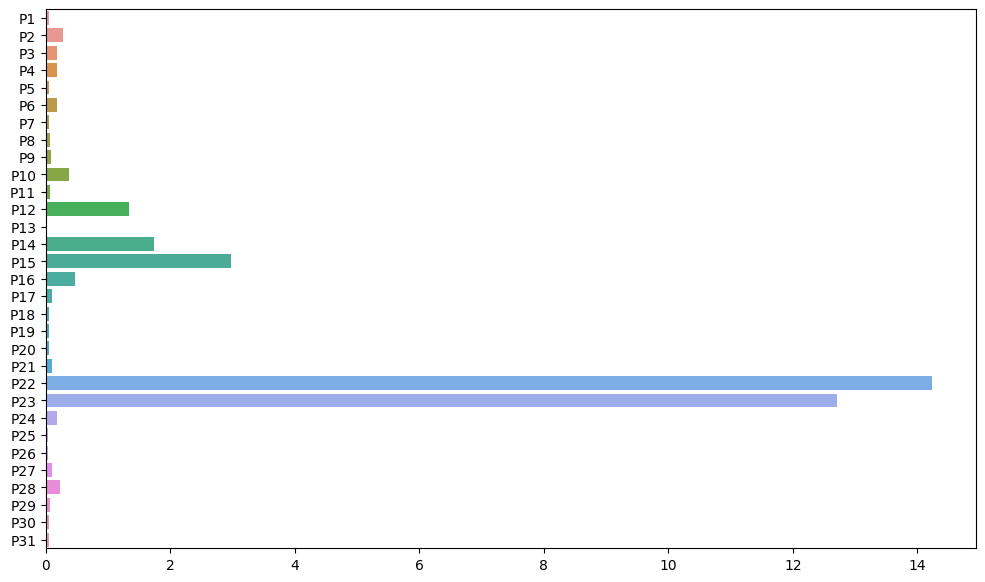

In [73]:
training_prep_df = v5_preprocessing(training_df, fill_nan=0, normalize_method='standard_scaler')
training_cols = list(training_prep_df.columns)
X, y = training_prep_df.to_numpy(), training_df['Target'].to_numpy().reshape(-1, 1)

best_params = {
    'C': 99,
    'dual': True,
    'loss': 'hinge',
    'max_iter': 8200,
    'penalty': 'l2',
    'tol': 0.000553
}
lsvc = LinearSVC(**best_params)

lsvc.fit(X, y)
coefs = np.abs(lsvc.coef_)

_, ax = plt.subplots(figsize=(12, 7))
sns.barplot(x=coefs.flatten(), y=training_cols, ax=ax);

n = 3
top_n_features = [training_cols[fi] for fi in np.argsort(coefs).flatten()][-n:]
print(top_n_features)

#### Feature elemination method

In [28]:
def get_roc_auc_score(model, X, y):
    skf = StratifiedKFold(n_splits=3, random_state=RAND_SEED, shuffle=True)
    
    scores_roc = []
    for train_ind, test_ind in skf.split(X, y):
        x_train, y_train = X[train_ind], y[train_ind]
        x_test, y_test = X[test_ind], y[test_ind]

        model.fit(x_train, y_train)
        y_score_pred = model.predict_proba(x_test)
        
        if len(y_score_pred.shape) == 2:
            y_score_pred = y_score_pred[:, 1]
        if len(y_score_pred.shape) == 1:
            y_score_pred = y_score_pred.reshape(-1, 1)
    
        scores_roc.append(roc_auc_score(y_test, y_score_pred))
    
    scores_roc = np.array(scores_roc)
    return scores_roc.mean()

['P16', 'P23', 'P22']


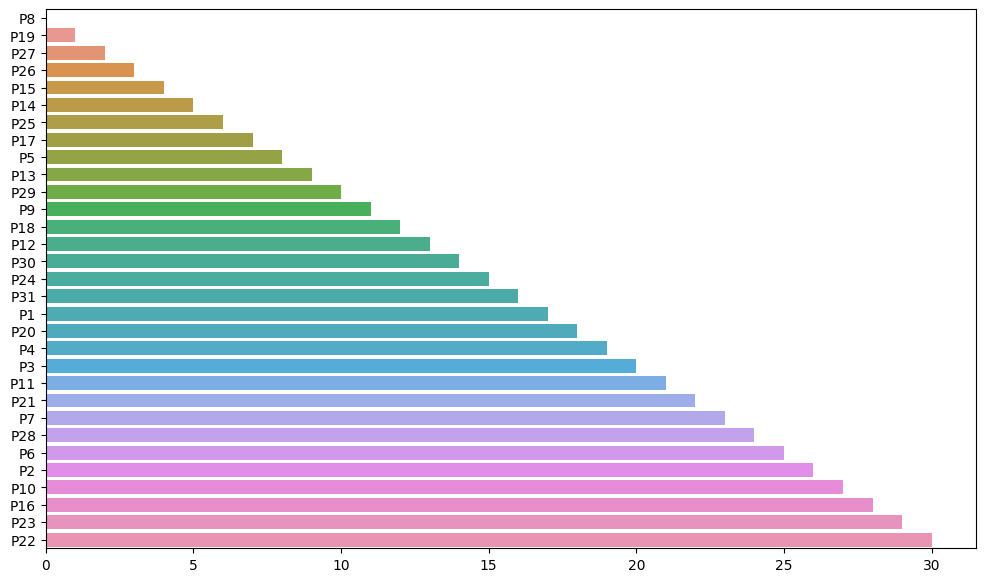

In [29]:
best_params = {
    'C': 99,
    'dual': True,
    'loss': 'hinge',
    'max_iter': 8200,
    'penalty': 'l2',
    'tol': 0.000553
    }

importance = dict()
cols = [i for i in training_df.columns if i not in ['ID', 'Target']]
for col in cols:
    dropcols = ['ID', 'Target', col]
    training_prep_df = v5_preprocessing(training_df, fill_nan=0, normalize_method='standard_scaler', dropcols=dropcols)
    X, y = training_prep_df.to_numpy(), training_df['Target'].to_numpy().reshape(-1, 1)

    model = CalibratedClassifierCV(LinearSVC(**best_params))
    score = get_roc_auc_score(model, X, y)
    
    importance[col] = score

importance = dict(sorted(importance.items(), key=lambda x: x[1], reverse=True))
features = list(importance.keys())
ranks = list(range(len(features)))

_, ax = plt.subplots(figsize=(12, 7))
sns.barplot(x=ranks, y=features, ax=ax);

print(features[-3:])

### ROC plot

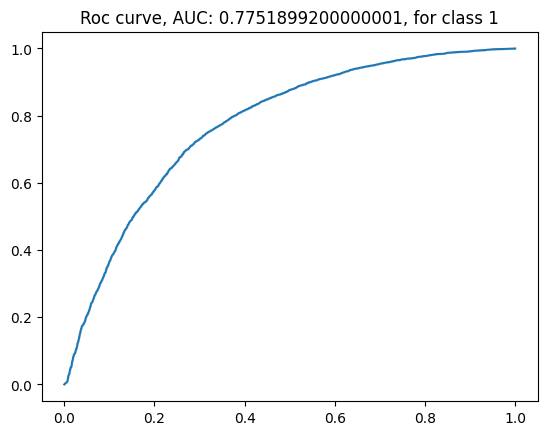

In [21]:
training_prep_df = v5_preprocessing(training_df, fill_nan=0, normalize_method='standard_scaler')
X, y = training_prep_df.to_numpy(), training_df['Target'].to_numpy().reshape(-1, 1)

best_params = {
    'C': 99,
    'dual': True,
    'loss': 'hinge',
    'max_iter': 8200,
    'penalty': 'l2',
    'tol': 0.000553
    }
lsvc = CalibratedClassifierCV(LinearSVC(**best_params))

# get true targets and pred scores
Y_test, Y_score_pred, auc_score = [], [], []
skf = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)
for train_ind, test_ind in skf.split(X, y):
    x_train, y_train = X[train_ind], y[train_ind]
    x_test, y_test = X[test_ind], y[test_ind]
    
    lsvc.fit(x_train, y_train)
    y_score_pred = lsvc.predict_proba(x_test)
        
    if len(y_score_pred.shape) == 2:
        y_score_pred = y_score_pred[:, 1]
    if len(y_score_pred.shape) == 1:
        y_score_pred = y_score_pred.reshape(-1, 1)
        
    Y_test.append(y_test)
    Y_score_pred.append(y_score_pred)
    auc_score.append(roc_auc_score(y_test, y_score_pred))
    
# get fpr, tpr, auc
Y_test, Y_score_pred = np.concatenate(Y_test), np.concatenate(Y_score_pred)
auc_score = np.array(auc_score).mean()
fpr, tpr, _ = roc_curve(Y_test, Y_score_pred)

_, ax = plt.subplots()
sns.lineplot(x=fpr, y=tpr, ax=ax);
ax.set_title(f"Roc curve, AUC: {auc_score}, for class 1");

### Submit

In [27]:
training_prep_df = v5_preprocessing(training_df, fill_nan=0, normalize_method='standard_scaler')
validate_prep_df = v5_preprocessing(validate_df, fill_nan=0, normalize_method='standard_scaler')
X_train, y_train = training_prep_df.to_numpy(), training_df['Target'].to_numpy().reshape(-1, 1)
X_test = validate_prep_df.to_numpy()

best_params = {
    'C': 99,
    'dual': True,
    'loss': 'hinge',
    'max_iter': 8200,
    'penalty': 'l2',
    'tol': 0.000553
    }
lsvc = CalibratedClassifierCV(LinearSVC(**best_params))

lsvc.fit(X_train, y_train)
target_predicts = lsvc.predict(X_test)

target_df = pd.DataFrame(target_predicts, columns=['Target'])
target_df.to_csv(SAVE_PATH, index=False)

assert target_predicts.shape[0] == len(target_df) == len(validate_df)